In [0]:
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
df = spark.read.parquet(bucket_dir + 'VM2Uniform--AK--2021-02-03')

We want to create a model to predict the party affiliation of a voter (Parties_Description), using seven predictors that are indicators of socioeconomic status: 

CommercialData_EstimatedHHIncome, Ethnic_Description, Voters_gender, CommercialData_EstHomeValue, CommercialData_Education, Voters_age, and CommercialData_OccupationGroup

Here, we'll implement a **Lasso Logistic Regression** model to see if the penalty applied to less important features will improve model accuracy. Also, this will hopefully give us insight into which of these socioeconomic features are less important and may remove these features entirely. 

In [0]:
# Data Preprocessing

from sklearn.model_selection import train_test_split
from pyspark.sql.functions import when, col, count, regexp_replace, lit
from pyspark.ml.feature import StringIndexer
from pyspark.sql import DataFrame

df = df.filter(~col("Parties_Description").isin(["Unknown", "Other"]))

# Convert Voters_Gender to binary
df = df.withColumn(
    "Voters_Gender",
    when(col("Voters_Gender") == "M", 1).otherwise(0)
)

# Convert CommercialData_EstHomeValue to numeric
df = df.withColumn(
    "CommercialData_EstHomeValue",
    regexp_replace(col("CommercialData_EstHomeValue"), "\\$", "").cast("float")
)

df = df.withColumn("CommercialData_EstHomeValue", col("CommercialData_EstHomeValue").cast("float"))

# Convert Voters_Age to numeric with error coercion
df = df.withColumn("Voters_Age", col("Voters_Age").cast("float"))

relevant_cols = [
    "CommercialData_EstimatedHHIncome", "Ethnic_Description", "Voters_Gender",
    "CommercialData_EstHomeValue", "CommercialData_Education",
    "Voters_Age", "CommercialData_OccupationGroup", "Parties_Description"
]
df = df.dropna(subset=relevant_cols)

train_df, test_df = df.randomSplit([0.8, 0.2], seed=56)

In [0]:

label_col = "Parties_Description"
class_counts = df.groupBy(label_col).count()
#class_counts.show()

In [0]:
predictor_cols = [
    "CommercialData_EstimatedHHIncome", "Ethnic_Description", "Voters_Gender",
    "CommercialData_EstHomeValue", "CommercialData_Education",
    "Voters_Age", "CommercialData_OccupationGroup"]

train_df = train_df.select(predictor_cols + [label_col])
test_df = test_df.select(predictor_cols + [label_col])

categorical_cols = [field for (field, dtype) in train_df.dtypes if dtype == "string" or dtype == "boolean"]
numeric_cols = [field for (field, dtype) in train_df.dtypes if dtype in ("int", "double", "float")]

#print(categorical_cols)
#print(numeric_cols)


['CommercialData_EstimatedHHIncome', 'Ethnic_Description', 'CommercialData_Education', 'CommercialData_OccupationGroup', 'Parties_Description']
['Voters_Gender', 'CommercialData_EstHomeValue', 'Voters_Age']


In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

label_indexer = StringIndexer(inputCol=label_col, outputCol=f"{label_col}_idx", handleInvalid="keep")

cat_feat = [col for col in categorical_cols if col != label_col]

# 3. StringIndexer + OneHotEncoder for categorical variables
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='keep') for col in cat_feat]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe") for col in cat_feat]

# 4. Assemble all features
assembler_inputs = [f"{col}_ohe" for col in cat_feat] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# 4. Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# 5. Logistic Regression model (L1 penalty for sparsity)
lr = LogisticRegression(
    featuresCol="scaled_features",
    labelCol=f"{label_col}_idx",  # Use the indexed label column
    elasticNetParam=1.0,
    regParam=0.0,
    maxIter=1000
)

# 6. Build pipeline
pipeline = Pipeline(stages=[label_indexer] + indexers + encoders + [assembler, scaler, lr])

#print(train_df)

# 7. Fit the pipeline
model = pipeline.fit(train_df)

# 8. Predict on test set
predictions = model.transform(test_df)

DataFrame[CommercialData_EstimatedHHIncome: string, Ethnic_Description: string, Voters_Gender: int, CommercialData_EstHomeValue: float, CommercialData_Education: string, Voters_Age: float, CommercialData_OccupationGroup: string, Parties_Description: string]


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run selective-fawn-783 at: https://805922955002043.3.gcp.databricks.com/ml/experiments/2916423882470509/runs/df62ac9ca80d44628cbc68c0310acb62
🧪 View experiment at: https://805922955002043.3.gcp.databricks.com/ml/experiments/2916423882470509
F1 Score: 0.32943066677774924


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol=f"{label_col}_idx", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol=f"{label_col}_idx", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print(f"Precision: {precision:.4f}")

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol=f"{label_col}_idx", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print(f"Recall: {recall:.4f}")

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol=f"{label_col}_idx", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.4686
Precision: 0.3861
Recall: 0.4686
F1 Score: 0.3294


Here, we see an accuracy of 0.47, but as we will see in the confusion matrix, it's actually worse than it seems because it predicted **Republican** for the vast majority of observations.

The F1 Score of 0.33 isn't great either, and the recall being better than the precision makes sense due to the large number of Republican predictions that were correct. 

In [0]:
y_true_pred = predictions.select("Parties_Description_idx", "prediction")

# Convert to Pandas (be cautious with large datasets)
y_true_pred_pd = y_true_pred.toPandas()

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true_pred_pd["Parties_Description_idx"], y_true_pred_pd["prediction"])

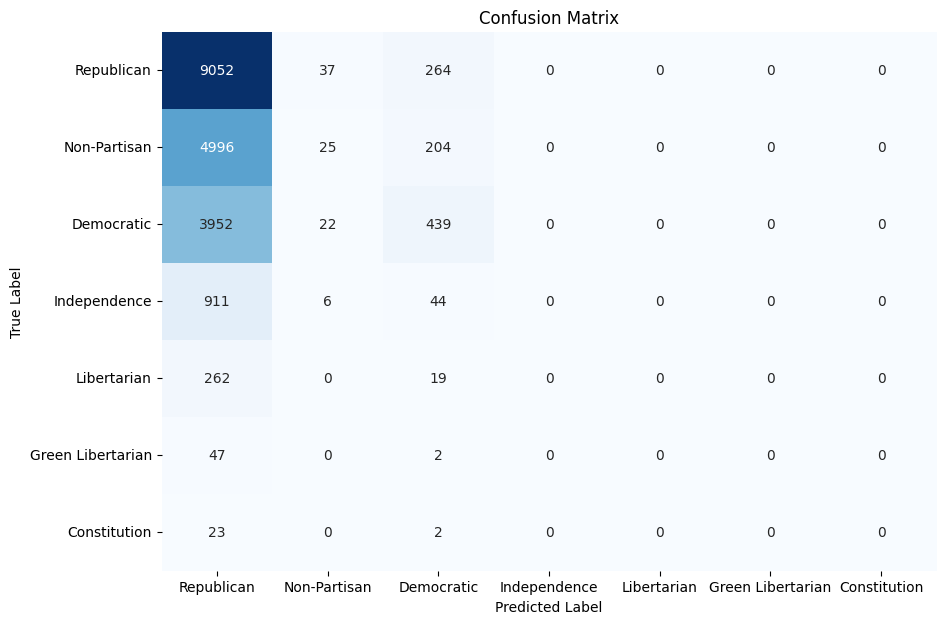

In [0]:
label_mapping = {
    0: 'Republican',
    1: 'Non-Partisan',
    2: 'Democratic',
    3: 'Independence',
    4: 'Libertarian',
    5: 'Green Libertarian',
    6: 'Constitution'
}

labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [0]:
total = df.count()

# Get normalized value counts
df.groupBy(label_col).count() \
  .withColumn("proportion", col("count") / lit(total)) \
  .orderBy("count", ascending=False) \
  .show()

+-------------------+-----+--------------------+
|Parties_Description|count|          proportion|
+-------------------+-----+--------------------+
|         Republican|46580| 0.46075929333095933|
|       Non-Partisan|26192|  0.2590856034977348|
|         Democratic|21859|  0.2162245039270382|
|       Independence| 4624| 0.04573960868102954|
|        Libertarian| 1460|0.014442004471086315|
|  Green Libertarian|  297|0.002937859813638...|
|       Constitution|   82| 8.11126278513067E-4|
+-------------------+-----+--------------------+



As seen above, the Lasso Regression predictor didn't predict any data points to belong in the four smallest classes, which is a typical challenge of this method in multiclass situations. 

It doesn't make much sense to resample here, as the most common class, Republican, only accounts for 46% of the data, and we don't want to overrepresent smaller classes. 

From this model, we can conclude that **Lasso** isn't the best method for dealing with this multiclass problem. Also, it is likely that the socioeconomic predictors we are examining aren't sufficient to make good predictions on party affiliation. 

It is also interesting to note that using these predictors, Republicans were overpredicted in the model, which could be due to model choice, predictor choice, or a combination of the two. 